**For Accessing Drive Contents**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

**NumtaDB** is a database.  The NumtaDB database contains handwritten Bengali digits (০ through ৯) and can provide a baseline for testing Bengali digit recognition using the machine and deep learning architecture.

<div align="center">
<img src="https://drive.google.com/uc?id=1Y6Xy0VzlVYmKp-4ZZ8UNaCZ1mBT5WxP7" width="300">
<img src="https://drive.google.com/uc?id=1TtnZP23KR-WRAvlXAIWNY_9zGIAiM_h0"width="300">
<figcaption>figure 1: NumtaDB dataset Snapshot</figcaption>
</div>



<div align="center">
<img src="https://drive.google.com/uc?id=1xe_bR1x1IDN-stNX5guGR6pfm3F5RQ3Q" width="600">
<figcaption>figure 2: NumtDB Network </figcaption>
<div/>





**Importing Necessary Libaries**

In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

- **Input dimension:**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - ০   ১   ২   ৩   ৪   ৫   ৬   ৭   ৮   ৯ 


*   **Dataset Length : 54908**








**Google Drive directory for Files**

In [ ]:
PATH = '/content/gdrive/MyDrive/sc_data_as1/namtadb/'
os.listdir(PATH)

['Namta_logistic.pkl',
 'Namta_logistic44.pkl',
 'Namta_logistic45.pkl',
 'Namta_logistica1.pkl',
 'Namta_logistica2.pkl',
 'Namta_logistica3.pkl',
 'Namta_logistica4.pkl',
 'Namta_logistica5.pkl',
 'testing-a',
 'testing-all-corrected',
 'testing-auga',
 'testing-augc',
 'testing-b',
 'testing-c',
 'testing-d',
 'testing-e',
 'testing-f',
 'train',
 'training-a',
 'training-a.csv',
 'training-b',
 'training-b.csv',
 'training-c',
 'training-c.csv',
 'training-d',
 'training-d.csv',
 'training-e',
 'training-e.csv',
 'trainy3',
 'trainy3csv']

**A function for reading data from CSV files**

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

In [ ]:
a_csv = showRawTrainingSamples('training-a.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)
c_csv = dropColumns(c_csv)
d_csv = dropColumns(d_csv)

         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0
         filename  digit
0      c00000.png      6
1      c00001.png      1
2      c00002.png      3
3      c00003.png      2
4      c00004.png      7
...           ...    ...
24293  c24293.png      3
24294  c24294.png      2
24295  c24295.png      7
24296  c24296.png      2
24297  c24297.png      7

[24298 rows x 2 columns]
     filename  digit
0  c00000.png      6
1  c00001.png      1
2  c00002.png      3
3  c00003.png      2
4  c00004.png      7
         filename  digit
0      d00000.png      1
1      d00001.png      1
2      d00002.png    

**Merging CSV files**

In [ ]:
total_csv = [a_csv, c_csv,d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

54908


**Create a Path for merged Images on Drive**

In [ ]:
TRAIN_PATH = '/content/gdrive/MyDrive/sc_data_as1/namtadb/trainy'
#os.mkdir(TRAIN_PATH)

**Merging image Function**

In [ ]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)

In [ ]:
processImages('training-a')
print('A Complete')
processImages('training-c')
print('C Complete')
processImages('training-d')
print('D Complete')

A Complete
C Complete
D Complete


**Create a Custom Dataset Function**

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]
c=1

train_transform = transforms.Compose([
    transforms.Grayscale(c),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Grayscale(c),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  54908


#Hyper Parameter


*  **Epochs:**
One Epoch is when an entire dataset is passed forward and backward through the neural network only once.
*  **Batch Size:**
Total number of training examples present in a single batch.

*  **Iterations:** Iterations is the number of batches needed to complete one epoch.


* **Learning Rate:** The amount that the weights are updated during training is referred to as the step size or the “learning rate.”











#**Hyper Parameter Tuning**

##Case 01
 I took  **batch size**,**iteration** and **learning rate** in accordance of **400,12000,0.0009**.The length of the dataset was 54908. So,

> $epoch$ $number = (12000*400)/54908 = 87 epoches$


> For this Setting I used 3 layer Deep Neural Network Model. In the first Layer, I used the LeakyReLU activation function. Then in the second layer, I used the same activation and In the final layer, I used ReLu as activation.


> In the first Layer I used 200 as hidden layer value, in the second layer I used 100 as Hidden Layer value and in the third 50 as hidden layer value.





> After Implementing I found **82.16%** accuracy with this setting.




           



In [ ]:
#setting hpt 2
#Case2
#HyperParameterTuning6
batch_size = 400
num_iters = 12000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 200
num_hidden1 = 100
num_hidden2 = 50

learning_rate = 0.0009
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Sending data to train and test loader**

In [ ]:
# split data 10% for testing
test_size = 0.1
train_data[0]
# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
#print(indices)
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
#print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]
#print(train_idx)
#print(test_idx)

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
#print(train_sampler)
#print(test_sampler)
# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

#print("Train dataloader:{}".format(len(train_loader)))
#print("Test dataloader:{}".format(len(test_loader)))

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
print(len(train_idx))
print(len(test_idx))

87
49418
5490


In [ ]:
#hp2
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden1)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden1, num_hidden2)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()
        

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden2, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): LeakyReLU(negative_slope=0.01)
  (linear_2): Linear(in_features=200, out_features=100, bias=True)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

**For optimizer I used Adam**

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_data[18][0].numpy().shape

(1, 28, 28)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#hp2
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 1.876231074333191. Accuracy: 35.40983606557377
Iteration: 1000. Loss: 1.7023825645446777. Accuracy: 43.29690346083789
Iteration: 1500. Loss: 1.4085110425949097. Accuracy: 48.233151183970854
Iteration: 2000. Loss: 1.3646397590637207. Accuracy: 55.591985428051004
Iteration: 2500. Loss: 1.2306727170944214. Accuracy: 60.58287795992714
Iteration: 3000. Loss: 1.075369954109192. Accuracy: 62.677595628415304
Iteration: 3500. Loss: 0.984040379524231. Accuracy: 68.79781420765028
Iteration: 4000. Loss: 0.9830719232559204. Accuracy: 70.09107468123861
Iteration: 4500. Loss: 0.8626294136047363. Accuracy: 72.55009107468123
Iteration: 5000. Loss: 0.8057286739349365. Accuracy: 71.43897996357013
Iteration: 5500. Loss: 0.910329282283783. Accuracy: 73.80692167577413
Iteration: 6000. Loss: 0.791054368019104. Accuracy: 76.28415300546447
Iteration: 6500. Loss: 0.6918980479240417. Accuracy: 73.24225865209472
Iteration: 7000. Loss: 0.5957208871841431. Accuracy: 76.6120218579235
Iteration:

##Case 02
 I took  **batch size**,**iteration** and **learning rate** in accordance of **400,11000,0.0009**.The length of the dataset was 54908. So,

> $epoch$ $number = (11000*400)/54908 = 80 epoches$

> For this Setting I used 3 layer Deep Neural Network Model. In the first Layer, I used the SiLU activation function. Then in the second layer, I used the LeakyReLU activation and In the final layer, I used ReLu as activation.


> In the first Layer I used 200 as hidden layer value, in the second layer I used 100 as Hidden Layer value, and in the third 50 as hidden layer value.

> After Implementing I found **78.17%** accuracy with this setting.




           



In [ ]:
#setting hpt 3
#Case2
#HyperParameterTuning6
batch_size = 400
num_iters = 11000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 200
num_hidden1 = 100
num_hidden2 = 50
learning_rate = 0.0009
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Sending data to train and test loader**

In [ ]:
# split data 10% for testing
test_size = 0.1
train_data[0]
# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
#print(indices)
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
#print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]
#print(train_idx)
#print(test_idx)

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
#print(train_sampler)
#print(test_sampler)
# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

#print("Train dataloader:{}".format(len(train_loader)))
#print("Test dataloader:{}".format(len(test_loader)))

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
print(len(train_idx))
print(len(test_idx))

80
49418
5490


In [ ]:
#hp3
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.tanh = nn.SiLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden1)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden1, num_hidden2)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()
        
        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden2, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.tanh(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        out = self.relu_3(out)
        
       
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (tanh): SiLU()
  (linear_2): Linear(in_features=200, out_features=100, bias=True)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (relu_3): ReLU()
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

**For optimizer I used Adam**

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_data[18][0].numpy().shape

(1, 28, 28)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#hp3
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.7806227207183838. Accuracy: 34.3351548269581
Iteration: 1000. Loss: 1.577865719795227. Accuracy: 41.93078324225865
Iteration: 1500. Loss: 1.2760528326034546. Accuracy: 55.3551912568306
Iteration: 2000. Loss: 1.1734527349472046. Accuracy: 59.25318761384335
Iteration: 2500. Loss: 1.1957111358642578. Accuracy: 60.892531876138435
Iteration: 3000. Loss: 1.0195969343185425. Accuracy: 65.02732240437159
Iteration: 3500. Loss: 0.9943625926971436. Accuracy: 67.41347905282332
Iteration: 4000. Loss: 0.9125356078147888. Accuracy: 68.08743169398907
Iteration: 4500. Loss: 0.827934980392456. Accuracy: 70.0
Iteration: 5000. Loss: 0.7869237661361694. Accuracy: 73.1511839708561
Iteration: 5500. Loss: 0.6833692193031311. Accuracy: 72.73224043715847
Iteration: 6000. Loss: 0.7569196820259094. Accuracy: 75.77413479052824
Iteration: 6500. Loss: 0.6431966423988342. Accuracy: 72.11293260473589
Iteration: 7000. Loss: 0.6190274357795715. Accuracy: 76.48451730418944
Iteration: 7500. Loss: 0

##Case 03
  I took  **batch size**,**iteration** and **learning rate** in accordance of **450,11000,0.0009**.The length of the dataset was 54908. So,

> $epoch$ $number = (11000*450)/54908 = 90 epoches$

> For this Setting I used 3 layer Deep Neural Network Model. In the first Layer, I used the SiLU activation function. Then in the second layer, I used the LeakyReLU activation and In the final layer, I used again LeakyReLU as activation.


> In the first Layer I used 200 as hidden layer value, in the second layer I used 100 as Hidden Layer value, and in the third 50 as hidden layer value.

> After Implementing I found **84.37%** accuracy with this setting.




           



In [ ]:
#setting hpt 4
#HyperParameterTuning44
batch_size = 450
num_iters = 11000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 200
num_hidden1 = 100
num_hidden2 = 50
learning_rate = 0.0009
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Sending data to train and test loader**

In [ ]:
# split data 10% for testing
test_size = 0.1
train_data[0]
# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
#print(indices)
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
#print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]
#print(train_idx)
#print(test_idx)

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
#print(train_sampler)
#print(test_sampler)
# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

#print("Train dataloader:{}".format(len(train_loader)))
#print("Test dataloader:{}".format(len(test_loader)))

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
print(len(train_idx))
print(len(test_idx))

90
49418
5490


In [ ]:
#hp4
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SiLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden1)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden1, num_hidden2)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.LeakyReLU()
        

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden2, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): SiLU()
  (linear_2): Linear(in_features=200, out_features=100, bias=True)
  (relu_2): LeakyReLU(negative_slope=0.01)
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

**For optimizer I used Adam**

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_data[18][0].numpy().shape

(1, 28, 28)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#hp4
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.745337963104248. Accuracy: 35.39162112932605
Iteration: 1000. Loss: 1.433962106704712. Accuracy: 50.21857923497268
Iteration: 1500. Loss: 1.2898684740066528. Accuracy: 58.08743169398907
Iteration: 2000. Loss: 1.117817759513855. Accuracy: 63.36976320582878
Iteration: 2500. Loss: 0.9566260576248169. Accuracy: 67.85063752276866
Iteration: 3000. Loss: 1.0002117156982422. Accuracy: 67.3224043715847
Iteration: 3500. Loss: 0.7941926121711731. Accuracy: 72.55009107468123
Iteration: 4000. Loss: 0.9363938570022583. Accuracy: 74.26229508196721
Iteration: 4500. Loss: 0.7328470945358276. Accuracy: 72.9143897996357
Iteration: 5000. Loss: 0.7108138799667358. Accuracy: 73.35154826958106
Iteration: 5500. Loss: 0.606046736240387. Accuracy: 77.57741347905282
Iteration: 6000. Loss: 0.7516129016876221. Accuracy: 78.56102003642987
Iteration: 6500. Loss: 0.5880290865898132. Accuracy: 76.39344262295081
Iteration: 7000. Loss: 0.5122608542442322. Accuracy: 79.1256830601093
Iteration: 750

##Case 04
  I took  **batch size**,**iteration** and **learning rate** in accordance of **450,11000,0.0009**.The length of the dataset was 54908. So,

> $epoch$ $number = (11000*450)/54908 = 90 epoches$

> For this Setting I used 3 layer Deep Neural Network Model. In the first Layer, I used the SiLU activation function. Then in the second layer, I used the RReLU activation and In the final layer, I used LeakyReLU as activation.


> In the first Layer I used 200 as hidden layer value, in the second layer I used 100 as Hidden Layer value, and in the third 50 as hidden layer value.

> After Implementing I found **77.85%** accuracy with this setting.



           



In [ ]:
#setting hpt 5
batch_size = 450
num_iters = 11000
input_dim = 28*28 # num_features = 784
output_dim = 10
num_hidden = 200
num_hidden1 = 100
num_hidden2 = 50
learning_rate = 0.0009
num_hidden = 100
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Sending data to train and test loader**

In [ ]:
# split data 10% for testing
test_size = 0.1
train_data[0]
# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
#print(indices)
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
#print(split)
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]
#print(train_idx)
#print(test_idx)

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
#print(train_sampler)
#print(test_sampler)
# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

#print("Train dataloader:{}".format(len(train_loader)))
#print("Test dataloader:{}".format(len(test_loader)))

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)
print(len(train_idx))
print(len(test_idx))

90
49418
5490


In [ ]:
#hp5
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.SiLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden1)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.RReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden1, num_hidden2)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.LeakyReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden2, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size=input_dim,
                                num_classes=output_dim,
                                num_hidden = num_hidden)

#To enable GPU
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (relu_1): SiLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): RReLU(lower=0.125, upper=0.3333333333333333)
  (linear_3): Linear(in_features=100, out_features=50, bias=True)
  (relu_3): LeakyReLU(negative_slope=0.01)
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

**For optimizer I used Adam**

The Adam optimization algorithm is an extension to stochastic gradient descent that has recently seen broader adoption for deep learning applications in computer vision and natural language processing.

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_data[18][0].numpy().shape

(1, 28, 28)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
#hp5
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear g radients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.7628687620162964. Accuracy: 38.59744990892532
Iteration: 1000. Loss: 1.568237066268921. Accuracy: 45.3551912568306
Iteration: 1500. Loss: 1.4109976291656494. Accuracy: 53.77049180327869
Iteration: 2000. Loss: 1.2420231103897095. Accuracy: 55.77413479052823
Iteration: 2500. Loss: 1.0742486715316772. Accuracy: 60.54644808743169
Iteration: 3000. Loss: 1.1234596967697144. Accuracy: 62.021857923497265
Iteration: 3500. Loss: 1.0690921545028687. Accuracy: 65.77413479052824
Iteration: 4000. Loss: 0.8893523216247559. Accuracy: 67.959927140255
Iteration: 4500. Loss: 0.8804792165756226. Accuracy: 70.01821493624772
Iteration: 5000. Loss: 0.8526207208633423. Accuracy: 70.52823315118397
Iteration: 5500. Loss: 0.920208215713501. Accuracy: 71.98542805100182
Iteration: 6000. Loss: 0.8122598528862. Accuracy: 71.85792349726776
Iteration: 6500. Loss: 0.9446526169776917. Accuracy: 72.78688524590164
Iteration: 7000. Loss: 0.6607643365859985. Accuracy: 72.47723132969034
Iteration: 750

## Comparison Table



**NumtaDB Dataset Comparision Table in Different Settings:-**

| Settings        | Batch Size     | Iteration Number|Learing rate   |Epochs|Number of Layer|Hidden Layer 01|Hidden Layer 02|Hidden Layer 03|Activation Function 01|Activation Function 02|Activation Function 03|Accuracy(%)|
| :------------- | :----------: | -----------: | ------------:|--------:|---------:|-------:|-------:|--------:|--------:|-----------:|--------:|-------:|
|  1 | 400   | 12000 |0.0009   | 87 |3|200|100|50|LeakyReLU|LeakyReLU|ReLU|**82.16**|
|  2 | 400   | 11000 |0.0009  | 80 |3|200|100|50|SiLU|LeakyReLU|ReLU|78.17|
|  3 | 450  | 11000  |0.0009  | 90 |3|200|100|50|SiLU|LeakyReLU|LeakyReLU|**84.37**|
|  4 | 450  | 11000  |0.0009  | 90 |3|200|100|50|SiLU|RReLU|LeakyReLU|77.85|


[1.87, 1.7, 1.4, 1.36, 1.23, 1.07, 0.98, 0.98, 0.86, 0.8, 0.91, 0.79, 0.69, 0.59, 0.63, 0.65, 0.65, 0.64, 0.57, 0.52, 0.47]


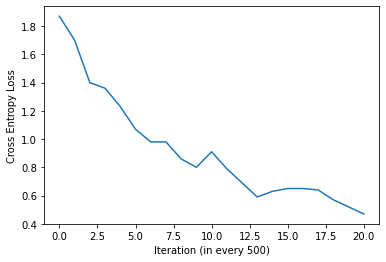

In [ ]:
#loss2
import matplotlib
import matplotlib.pyplot as plt
iteration_loss = [1.87,1.70,1.40,1.36,1.23,1.07,.98,.98,.86,.80,.91,.79,.69,.59,.63,.65,.65,.64,.57,.52,.47]
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

[1.78, 1.57, 1.27, 1.17, 1.19, 1.01, 0.99, 0.91, 0.82, 0.78, 0.68, 0.75, 0.64, 0.61, 0.64, 0.66, 0.64, 0.54, 0.49]


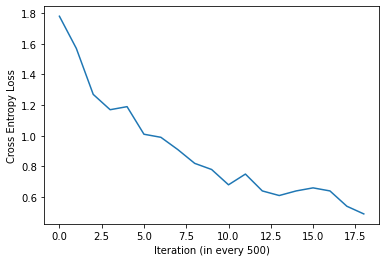

In [ ]:
#loss3
import matplotlib
import matplotlib.pyplot as plt
iteration_loss = [1.78,1.57,1.27,1.17,1.19,1.01,.99,.91,.82,.78,.68,.75,.64,.61,.64,.66,.64,.54,.49]
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

[1.74, 1.43, 1.28, 1.11, 0.95, 1.0, 0.79, 0.93, 0.73, 0.71, 0.6, 0.75, 0.58, 0.51, 0.57, 0.61, 0.5, 0.46, 0.52]


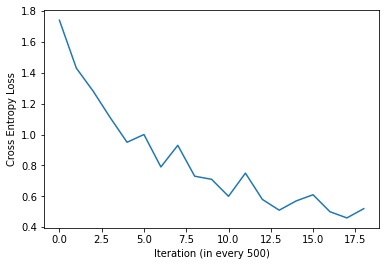

In [ ]:
#loss4
import matplotlib
import matplotlib.pyplot as plt
iteration_loss = [1.74,1.43,1.28,1.11,.95,1.0,0.79,0.93,.73,.71,.60,.75,.58,.51,.57,.61,.50,.46,.52]
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()


[1.76, 1.56, 1.41, 1.24, 1.07, 1.12, 1.06, 0.88, 0.88, 0.85, 0.92, 0.81, 0.94, 0.66, 0.6, 0.75, 0.61, 0.56, 0.59]


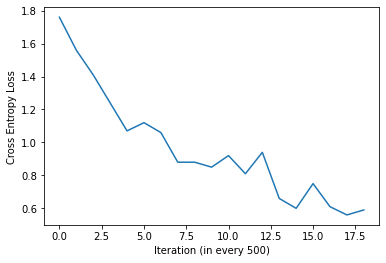

In [ ]:
#loss5
import matplotlib
import matplotlib.pyplot as plt
iteration_loss = [1.76,1.56,1.41,1.24,1.07,1.12,1.06,.88,.88,.85,.92,.81,.94,.66,.60,.75,.61,.56,.59]
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

[35.4, 43.29, 48.23, 55.59, 60.58, 62.67, 68.79, 70.09, 72.55, 71.43, 73.8, 76.28, 73.24, 76.61, 78.32, 76.61, 80.45, 79.18, 81.49, 78.06, 82.16]


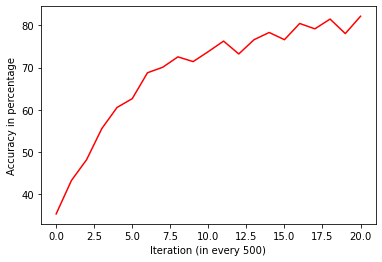

In [ ]:
#acc2
import matplotlib
import matplotlib.pyplot as plt
iteration_loss= [35.40,43.29,48.23,55.59,60.58,62.67,68.79,70.09,72.55,71.43,73.80,76.28,73.24,76.61,78.32,76.61,80.45,79.18,81.49,78.06,82.16]
print (iteration_loss)
plt.plot(iteration_loss,color="red")
plt.ylabel('Accuracy in percentage')
plt.xlabel('Iteration (in every 500)')
plt.show()

[34.33, 41.93, 55.35, 59.25, 60.89, 65.02, 67.41, 68.08, 70.0, 73.15, 72.73, 75.77, 72.11, 76.48, 78.97, 79.61, 77.72, 80.18, 78.77]


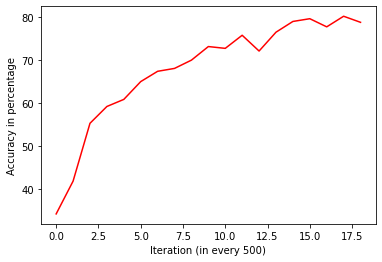

In [ ]:
#acc3
import matplotlib
import matplotlib.pyplot as plt
iteration_loss= [34.33,41.93,55.35,59.25,60.89,65.02,67.41,68.08,70.0,73.15,72.73,75.77,72.11,76.48,78.97,79.61,77.72,80.18,78.77]
print (iteration_loss)
plt.plot(iteration_loss,color="red")

plt.ylabel('Accuracy in percentage')
plt.xlabel('Iteration (in every 500)')
plt.show()

[35.39, 50.21, 58.08, 63.36, 67.85, 67.32, 72.55, 74.26, 72.91, 73.35, 77.57, 78.56, 76.39, 79.12, 79.45, 79.74, 81.73, 83.18, 84.37]


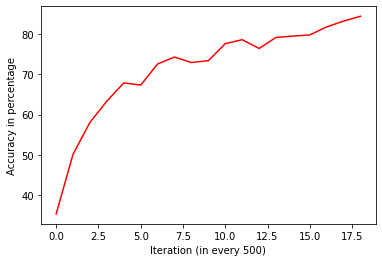

In [ ]:
#acc4
import matplotlib
import matplotlib.pyplot as plt
iteration_loss= [35.39,50.21,58.08,63.36,67.85,67.32,72.55,74.26,72.91,73.35,77.57,78.56,76.39,79.12,79.45,79.74,81.73,83.18,84.37]
print (iteration_loss)
plt.plot(iteration_loss,color="red")
plt.ylabel('Accuracy in percentage')
plt.xlabel('Iteration (in every 500)')
plt.show()

[38.59, 45.55, 53.77, 55.77, 60.54, 62.02, 65.77, 67.95, 70.01, 70.52, 71.98, 71.85, 72.78, 72.47, 74.99, 76.08, 77.32, 78.72, 77.85]


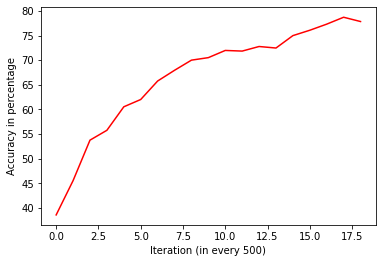

In [ ]:
#acc5
import matplotlib
import matplotlib.pyplot as plt
iteration_loss= [38.59,45.55,53.77,55.77,60.54,62.02,65.77,67.95,70.01,70.52,71.98,71.85,72.78,72.47,74.99,76.08,77.32,78.72,77.85]
print (iteration_loss)
plt.plot(iteration_loss,color="red")
plt.ylabel('Accuracy in percentage')
plt.xlabel('Iteration (in every 500)')
plt.show()

#Comparision Graph between Loss and Accuracy

**Case 1**
<div align="center">
<img src="https://drive.google.com/uc?id=1wz4C5DZL-4HkJPFUnx4b_qvD2YH98Ebl" width="300">
<img src="https://drive.google.com/uc?id=1QEMau3wrrG0NFAJunUtE14lmwGLLyF6o"width="300">
<figcaption>figure 2: Accuracy and Loss in Case 1 </figcaption>

**Case 2**
<div align="center">
<img src="https://drive.google.com/uc?id=1yqGP8XaV16PJ0-K7Ltx_o7HZBfNBaTf8" width="300">
<img src="https://drive.google.com/uc?id=1hUx2kpBqXi4lYhpNYi4sFOFrnEx_qdwG"width="300">
<figcaption>figure 3: Accuracy and Loss in Case 2 </figcaption>

**Case 3**
<div align="center">
<img src="https://drive.google.com/uc?id=1ZWANYvTUTCn1HSi0fKWYoYI82mecLkkO" width="300">
<img src="https://drive.google.com/uc?id=1IkcRcvphEX9w4hzzw8q7zHk4v-qR_kuW"width="300">
<figcaption>figure 4: Accuracy and Loss in Case 3 </figcaption>

**Case 4**
<div align="center">
<img src="https://drive.google.com/uc?id=1Dg9VoXTdglg9vHw3Oa6Tynx_I96uMBd4" width="300">
<img src="https://drive.google.com/uc?id=1l28u5eBqfzKJy8ycFrKmdm34uvn7ETPw"width="300">
<figcaption>figure 5: Accuracy and Loss in Case 4 </figcaption>

#Best Model

**Hyper Parameter Values**

$Batch$ $size = 450 $

$Iteration =11000$

$learning$ $Rate = 0.0009$

$Hidden$ $layer$ $1$ = $200$

$Hidden$ $layer$ $2$ = $100$

$Hidden$ $layer$ $3$ = $50$

$Activation$ $ 1$ = $SiLU$

$Activation$ $ 2$ = $LeakyReLU$

$Activation$ $ 3$ = $LeakyReLU$





$Accuracy($%$) = 84.37$

**My best Model able to predict 8 or 9 digits correctly out of 10 in my testing.**

**Model Saving Code**

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), PATH + 'Namta_logistica5.pkl') 

**Load Image From Test Loader**

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(PATH + 'Namta_logistica5.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


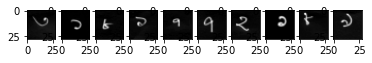

In [ ]:
#hp2
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)


plt.show()

In [ ]:
#hp2
predictions = model.forward(images[:10].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [3 1 8 9 7 7 2 1 8 9]


# Drive Links for Train Models

> **Setting 1:** [https://drive.google.com/file/d/1addecxE2zGxWMlk8e21_oWTNB1b0HYw8/view?usp=sharing](https://)

> **Setting 2:** [https://drive.google.com/file/d/16YKTR8M2l_QC-Qz_pxiBJwJyYky0ytV2/view?usp=sharing](https://)

> **Setting 3:** [https://drive.google.com/file/d/1q4eBzdVkNeIoTUdOn9WfrJRALtE8tC5L/view?usp=sharing](https://)

> **Setting 4:** [https://drive.google.com/file/d/1dcFXdPY1K7lHqq68Mxy4TGvqJkx71Uhy/view?usp=sharing](https://)

